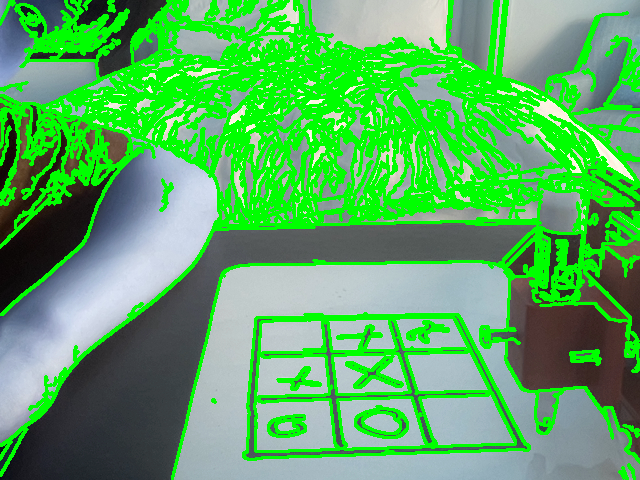

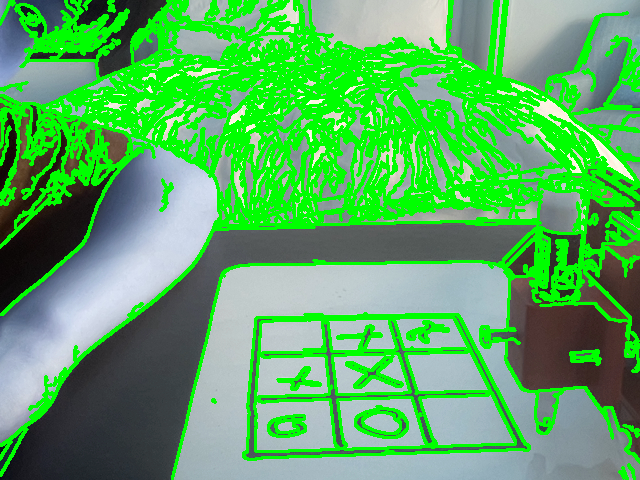

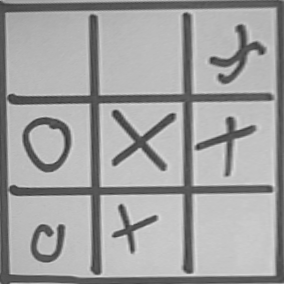

20 20.0


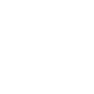

40 40.0
20 20.0


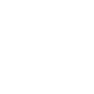

40 40.0
20 20.0
21245350
[47.0, 47.0]
[47.5, 49.0]


NameError: name 'ai' is not defined

In [2]:
# app.py
import tensorflow as tf
from flask import Flask, request, jsonify
import cv2
import numpy as np
from PIL import Image
import io
from google.colab.patches import cv2_imshow




def make_edges_white(image, w,center):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    offset_height = (image.shape[1] / 2) - center[1]
    offset_width = (image.shape[0]/2) - center[0]
    #offset_width = image.shape[1] / 2

    # Create a binary mask where the edges will be white
    mask = np.zeros_like(gray)

    # Define the edge width in pixels
    edge_width = w
    print(str(edge_width) + " " + str(edge_width-offset_height))
    # Set the edge region of the mask to white
    mask[0:int(edge_width-(2*offset_width)), :] = 255 #try swittching them?
    mask[int(-edge_width+offset_width):, :] = 255
    mask[:, 0:int(edge_width-offset_height)] = 255
    mask[:, int(-edge_width+offset_height):] = 255

    # Combine the mask with the grayscale image
    # The mask will be applied to the grayscale image to make the edges white
    result = gray.copy()
    result[mask == 255] = 255
    #cv2_imshow(result)
    return result


def img():

    image_file = "/My photo - Date (4).jpg"
    image = Image.open(image_file).convert('RGB')
    image = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Edge detection
    edges = cv2.Canny(gray, 25, 100, apertureSize=3)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest square contour is the Tic-Tac-Toe board
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    board_contour = None
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    #cv2.imwrite('contour_image.jpg', image)  # Save contour image
    cv2_imshow(image)

    for contour in contours:
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            board_contour = approx
            break

    if board_contour is None:
        return 'No Tic-Tac-Toe board found', 400
    board_contour_img = image.copy()
    cv2.drawContours(board_contour_img, contours, -1, (0, 255, 0), 2)
    #cv2.imwrite('board_contour_image.jpg', board_contour_img)  # Save contour image
    cv2_imshow( board_contour_img)
    # Warp perspective to get a top-down view of the board
    pts = np.float32([point[0] for point in board_contour])
    side = max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[1] - pts[2]),
               np.linalg.norm(pts[2] - pts[3]), np.linalg.norm(pts[3] - pts[0]))
    dst = np.float32([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]])
    matrix = cv2.getPerspectiveTransform(pts, dst)
    board = cv2.warpPerspective(gray, matrix, (int(side), int(side)))
    cv2_imshow( board)  # Save warped board image

    # Divide the board into 9 cells
    step = board.shape[0] // 3
    cells = []
    for i in range(3):
        for j in range(3):
            cell = board[i * step:(i + 1) * step, j * step:(j + 1) * step]




            cells.append(cell)

    # Placeholder for recognizing Xs and Os
    board_state = []
    # for cell in cells:
    #     edgess = cv2.Canny(cell, 50, 150, apertureSize=3)

    #     contours, _ = cv2.findContours(edgess, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #cell = cv2.drawContours(cell, contours, -1, (0, 255, 0), 2)
    # edgess = cv2.Canny(cells[0], 50,150, apertureSize=3)
    # contours, _ = cv2.findContours(edgess, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cells[0] = cv2.drawContours(cells[0], contours, -1, (0, 255, 0), 2)
    num = 5
    for cell in cells:
      center = [cell.shape[0]/2,cell.shape[1]/2]


      cell = make_edges_white(cell,20, center)

      threshold, black_pixels = cv2.threshold(cell, 100, 255,cv2.THRESH_BINARY)


      edges = cv2.Canny(black_pixels, 60, 150, apertureSize=3)
      contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours) > 0:
          x, y, w, h = cv2.boundingRect(contours[len(contours)-1])
          # cv2.drawContours(black_pixels, contours, -1, (0, 255, 0), 2)
          print(str(x) + str(y) + str(w) + str(h))
          #cv2.rectangle(black_pixels, (x, y), (x + w, y + h), (0, 255, 0), 2)
          print(center)
          center = [x+w/2,y+h/2]
          print(center)
          rgb = cv2.cvtColor(black_pixels, cv2.COLOR_GRAY2BGR)
          pil_compatible = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

          pil_image = Image.fromarray(pil_compatible)
          pil_image.show()
          result = ai(pil_image )
          print(result+ "result")
          if("Circle" in result):
            board_state.append("O")
          elif( "X" in result):
            board_state.append("X")
          else:
            board_state.append("blank")

          #cv2.drawContours(cell, contours, -1, (255, 255, 255), 2)
          # cv2.circle(black_pixels, (int(center[0]), int(center[1])), 10, (0, 0, 255), -1)
          #cv2_imshow(cell)
      cv2_imshow(black_pixels)



      pixel_count = cv2.countNonZero(black_pixels)
      black_pixels = make_edges_white(black_pixels,40,center)
      pixel_count_2 = cv2.countNonZero(black_pixels)



      if(pixel_count >= cell.size * 0.999999999):
        board_state.append("empty")


      # print(str(black_pixels) + " " +  str(cells[0].size))
      # image = cv2.resize(black_pixels, (224, 224), interpolation=cv2.INTER_AREA)
      # image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)
      # image = (image / 127.5) - 1
      # prediction = model.predict(image)
      # index = np.argmax(prediction)
      # class_name = class_names[index]
      # confidence_score = prediction[0][index]

      # # Print prediction and confidence score
      # print("Class:", class_name[2:], end="")
      # print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")





    # Respond with the board state

    # return board_state
    _, buffer = cv2.imencode('.png', board)  # Use '.jpg' for JPEG

    # Step 3: Convert the buffer to a base64 string
    # base64_string = base64.b64encode(buffer).decode('utf-8')
    # data_uri = f"data:image/png;base64,{base64_string}"

    return board_state
img()




In [ ]:
!pip install flask_cors

In [3]:
import os
import threading
import getpass
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
from flask_cors import CORS

conf.get_default().auth_token = "2kuJ2SpmZEZyRLbmwj8eCHrqeG2_n3z6FFgyHWMx2Eufe4Lf"

app = Flask(__name__)
CORS(app)
port = "4000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url
print(public_url)

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/", methods=["POST"])
def index():
    data = request.json
    base64_string = data.get("base64")

    if not base64_string:
        return jsonify({"error": "No base64 image data provided"}), 400

    try:
        image = readb64(base64_string)
    except Exception as e:
        return jsonify({"error": f"Image could not be read: {str(e)}"}), 400

    try:
        result = img(image)
    except Exception as e:
        result = f"error: {str(e)}"

    print(result)
    return jsonify({"result": result})

# Start the Flask server in a new thread
threading.Thread(target=app.run(port = port), kwargs={"use_reloader": False}).start()


ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
import base64

def readb64(uri):
  encoded_data = uri.split(',')[1]
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)
  img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
  return img


In [ ]:
!pip install pyngrok
!ngrok authtoken '2kuJ2SpmZEZyRLbmwj8eCHrqeG2_n3z6FFgyHWMx2Eufe4Lf'

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = PipSession(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/network/session.py", line 344, in __init__
    self.headers["User-Agent"] = user_agent()
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
#teachable machine code

In [4]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("keras_model.h5", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
def ai(image):


  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

  # turn the image into a numpy array
  image_array = np.asarray(image)

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

  # Load the image into the array
  data[0] = normalized_image_array

  #Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index].strip()
  confidence_score = prediction[0][index]
  print(f"Class: {class_name}, Confidence Score: {confidence_score}")
  return class_name

# Print prediction and confidence score
# print("Class:", class_name[2:], end="")
# print("Confidence Score:", confidence_score)


TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

In [5]:
!pip install tensorflow==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    U